In [1]:
import os
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import dlib

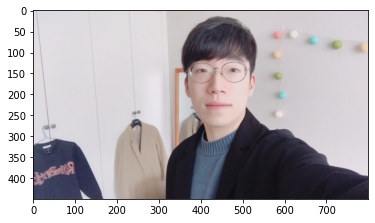

In [2]:
my_image_path = 'aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show()

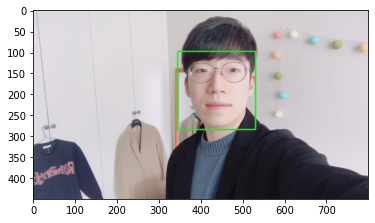

In [3]:
img_show = img_rgb.copy()

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

plt.imshow(img_show) 
plt.show()

출처 : https://ceuity.tistory.com/7

Object detection 기술을 이용해서 얼굴의 위치를 찾는다. dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.

굳이 내가 일일히 얼굴을 따로 사각형으로 잡지 않아도 알아서 찾아준다.

In [4]:
model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))


68


출처 : https://ceuity.tistory.com/7

이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다. face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용한다.

Object keypoint estimation 알고리즘 : 객체 내부의 점을 찾는 기술
top-down : bounding box를 찾고 box 내부의 keypoint를 예측
bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

마찬가지로 이목구비도 자동으로 데이터화 시켜준다. 총 68개의 랜드마크로 이루어져 있다.

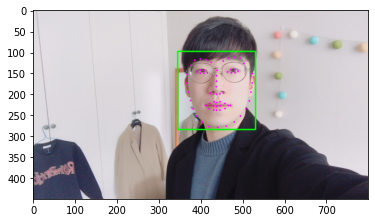

In [5]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (255, 0, 255), -1)

plt.imshow(img_show)

for문을 왜 쓰는지 이해를 못했음.
->랜드마크를 출력하기 위함

출처 : https://ai-rtistic.com/2021/08/02/toy-project-camera-app/

In [6]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


코의 중심점의 좌표를 확인

출처 : https://ai-rtistic.com/2021/08/02/toy-project-camera-app/

In [7]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인


(187, 187, 3)


코를 중심으로 알맞은 위치에 스티커 이미지를 적용

출처 : https://ai-rtistic.com/2021/08/02/toy-project-camera-app/

In [8]:
refined_x = x - w // 2 # 437 - (187//2) = 437-93 = 344
refined_y = y - h # 89-187 = -98
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (344,-98)


스티커를 붙일 위치를 지정

출처 : https://ai-rtistic.com/2021/08/02/toy-project-camera-app/

In [9]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')


(x,y) : (344,0)


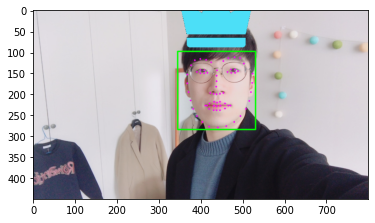

In [10]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)    #0이 아니고 255
plt.imshow(img_show) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()


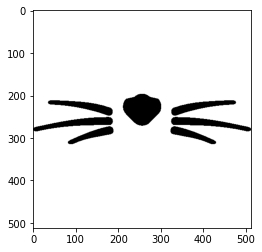

In [17]:

sticker_path2 = os.getenv('HOME')+'/aiffel/camera_sticker/images/24674.png'
img_sticker2 = cv2.imread(sticker_path2)
plt.imshow(img_sticker2)
plt.show()


     

구글링으로 검색(파일명, 이미지)해서 똑같은 사진 다운로드

In [18]:
img_sticker2.shape
img_sticker2 = cv2.resize(img_sticker2, (w,h))
img_sticker2.shape



(187, 187, 3)

In [19]:

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


In [21]:

refined_x2 = x - int(w/2)
refined_y2 = y 



구글링해도 알수가 없다.. ㅜ

In [22]:
if refined_x2 < 0: 
    img_sticker2 = img_sticker2[:, -refined_x2:]
    refined_x2 = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y2 < 0:
    img_sticker2 = img_sticker2[-refined_y2:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y2 = 0

print (f'(x,y) : ({refined_x2},{refined_y2})')

(x,y) : (344,89)


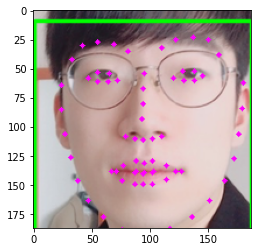

In [23]:
sticker_area2 = img_show[refined_y2:refined_y2+img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
plt.imshow(sticker_area2)
plt.show()



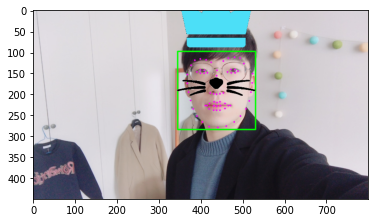

In [24]:
img_show[refined_y2:refined_y2+img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]] = \
    np.where(img_sticker2==255,sticker_area2,img_sticker2).astype(np.uint8)
plt.imshow(img_show) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()


참고 : https://github.com/andkspark/Exploration/blob/main/ex07_KSPARK.ipynb

노드를 계속 손도 못대다가, 그나마 파이썬 코딩을 좀 못해도 할 수 있는 과제라고 생각해서 하게 된 과제다. 실제로 구글링해보니 자료들이 많았었고, 코드들도 완벽하게는 아니지만 근접하게 이해할 수 있었다. 스터디&개인학습을 통해 파이썬을 확실하게 처음부터 끝까지 배워야되는 것을 다시 느꼈다.